In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.metrics
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
from typing import Optional

In [2]:
data = pd.read_csv(r"C:\\Users\\l.mora\\Downloads\\ElectricityTheftDetection_data\\data.csv", low_memory=False)

print(f"Total number of columns in the CSV:\t{len(data.columns)}")
print(f"Total number of instances:\t{len(data)}")
print(f"Column names:\n\t- {";\n\t- ".join(list(data.iloc[:, :20].columns))};\n\t- ...;\n\t- {";\n\t- ".join(list(data.iloc[:, -2:].columns))}.")

Total number of columns in the CSV:	1036
Total number of instances:	42372
Column names:
	- CONS_NO;
	- FLAG;
	- 2014/1/1;
	- 2014/1/10;
	- 2014/1/11;
	- 2014/1/12;
	- 2014/1/13;
	- 2014/1/14;
	- 2014/1/15;
	- 2014/1/16;
	- 2014/1/17;
	- 2014/1/18;
	- 2014/1/19;
	- 2014/1/2;
	- 2014/1/20;
	- 2014/1/21;
	- 2014/1/22;
	- 2014/1/23;
	- 2014/1/24;
	- 2014/1/25;
	- ...;
	- 2016/9/8;
	- 2016/9/9.


In [3]:
# New column formatting
date_names = data.iloc[:,2:].columns.map(
    lambda col: datetime.strptime(col, "%Y/%m/%d").strftime("%Y%m%d"))
new_col_names = pd.Index(["CONS_NO", "FLAG"]).append(date_names)
data.columns = new_col_names

# Alphabetical sorting (by date) of columns
data = data.reindex(sorted(data.columns), axis=1)

print(f"New column names:\n\t- {";\n\t- ".join(list(data.iloc[:, :20].columns))};\n\t- ...;\n\t- {";\n\t- ".join(list(data.iloc[:, -2:].columns))}.")

New column names:
	- 20140101;
	- 20140102;
	- 20140103;
	- 20140104;
	- 20140105;
	- 20140106;
	- 20140107;
	- 20140108;
	- 20140109;
	- 20140110;
	- 20140111;
	- 20140112;
	- 20140113;
	- 20140114;
	- 20140115;
	- 20140116;
	- 20140117;
	- 20140118;
	- 20140119;
	- 20140120;
	- ...;
	- CONS_NO;
	- FLAG.


In [4]:
target = 'FLAG'
target_labels = ["No Fraud", "Fraud"]

print(f"Target variable:\t{target}")

Target variable:	FLAG


In [5]:
data.interpolate(method='polynomial', order=2, axis=0, inplace=True)
data.fillna(0, axis=0, inplace=True)

C:\Users\l.mora\AppData\Local\Temp\ipykernel_22168\4141348559.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='polynomial', order=2, axis=0, inplace=True)


In [6]:
def filter_data_by_date(
        df: pd.DataFrame,
        starting_date: str,
        ending_date: str
    ) -> Optional[pd.DataFrame]:
    """Filter data according to the specified interval `[starting_date:ending_date)`."""
    try:
        start_index = df.columns.get_loc(starting_date)
        end_index = df.columns.get_loc(ending_date)
    except KeyError as e:
        print(f"Date {e} not found in DataFrame columns.")
        return

    return df.iloc[:, start_index:end_index]

In [7]:
def date_to_readable(date: str) -> str:
    """Convert a date string from 'YYYYMMDD' format to 'DD Mon YYYY' format."""
    try:
        return datetime.strptime(date, "%Y%m%d").strftime("%d %b %Y")
    except ValueError as e:
        raise ValueError(f"Invalid date format: {date}. Expected format is 'YYYYMMDD'.") from e

In [8]:
def filter_client_data(data: pd.DataFrame, client_id: str) -> pd.DataFrame:
    """Filter data for a specific client."""
    return data[data['CONS_NO'] == client_id]

def calculate_daily_average(df):
    """Calculate the daily average of consumption."""
    daily_avg = df.drop(columns=['CONS_NO', 'FLAG'], errors="ignore").mean(axis=0)
    return pd.DataFrame({"date": daily_avg.index, "avg": daily_avg.values})

def plot_comparison(
        avg_data: pd.DataFrame,
        honest_data: pd.DataFrame,
        fraudulent_data: pd.DataFrame,
        starting_date: str,
        ending_date: str
    ) -> None:
    """Plot the comparison of average, honest, and fraudulent customer data."""
    plt.figure(figsize=(12, 6), dpi=500)
    sns.lineplot(
        data=avg_data, x='date', y='avg',
        color='#073763', label='Daily AVG', linewidth=1.5)
    sns.lineplot(
        data=honest_data, x='date', y='avg',
        color='#3e9c15', label='Honest Customer', linewidth=1.2)
    sns.lineplot(
        data=fraudulent_data, x='date', y='avg',
        color='#cc0000', label='Fraudulent Customer', linewidth=1.2, linestyle='--')

    n_days = len(avg_data)
    plt.xticks(range(1, n_days, int(n_days*.2)),)
    plt.grid(True)
    plt.legend(loc='best', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.title('Consumption Discrepancy (Fraudulent and Honest)')
    plt.suptitle(('Consumption Comparison between Two Random Customers, '
                  'period: {} and {}'.format(
                      date_to_readable(starting_date),
                      date_to_readable(ending_date)
                    )), fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.show()

def random_comparison(
        df: pd.DataFrame,
        start_date: str = '20140101',
        end_date: str = '20161031'
    ):
    """
    Compare the monthly consumption between a fraudulent and
    non-fraudulent client, alongside the overall monthly average.
    """
    # Filter data according to the specified interval [start_date:end_date)
    filtered_cons = filter_data_by_date(
        df, starting_date=start_date, ending_date=end_date)
    if filtered_cons is None:
        print(f"No data found for the range: {start_date} to {end_date}")
        return
    data = pd.concat([df[['CONS_NO', 'FLAG']], filtered_cons], axis=1)

    # Separate fraudulent and non-fraudulent clients based on FLAG
    f_clients: np.ndarray = data[data['FLAG'] == 1]['CONS_NO'].unique()
    h_clients: np.ndarray = data[data['FLAG'] == 0]['CONS_NO'].unique()

    if len(f_clients) == 0 or len(h_clients) == 0:
        raise ValueError("No sufficient data for fraudulent or non-fraudulent clients in the dataset.")

    # Calculate daily average for all clients
    daily_avg_data = calculate_daily_average(filtered_cons)

    # Calculate daily average for a random honest client
    h_client_id = np.random.choice(h_clients)
    h_data = filter_client_data(data, h_client_id)
    h_daily_avg_data = calculate_daily_average(h_data)

    # Calculate daily average for a random fraudulent client
    f_client_id = np.random.choice(f_clients)
    f_data = filter_client_data(data, f_client_id)
    f_daily_avg_data = calculate_daily_average(f_data)

    # Plot the comparison
    plot_comparison(daily_avg_data, h_daily_avg_data, f_daily_avg_data, start_date, end_date)

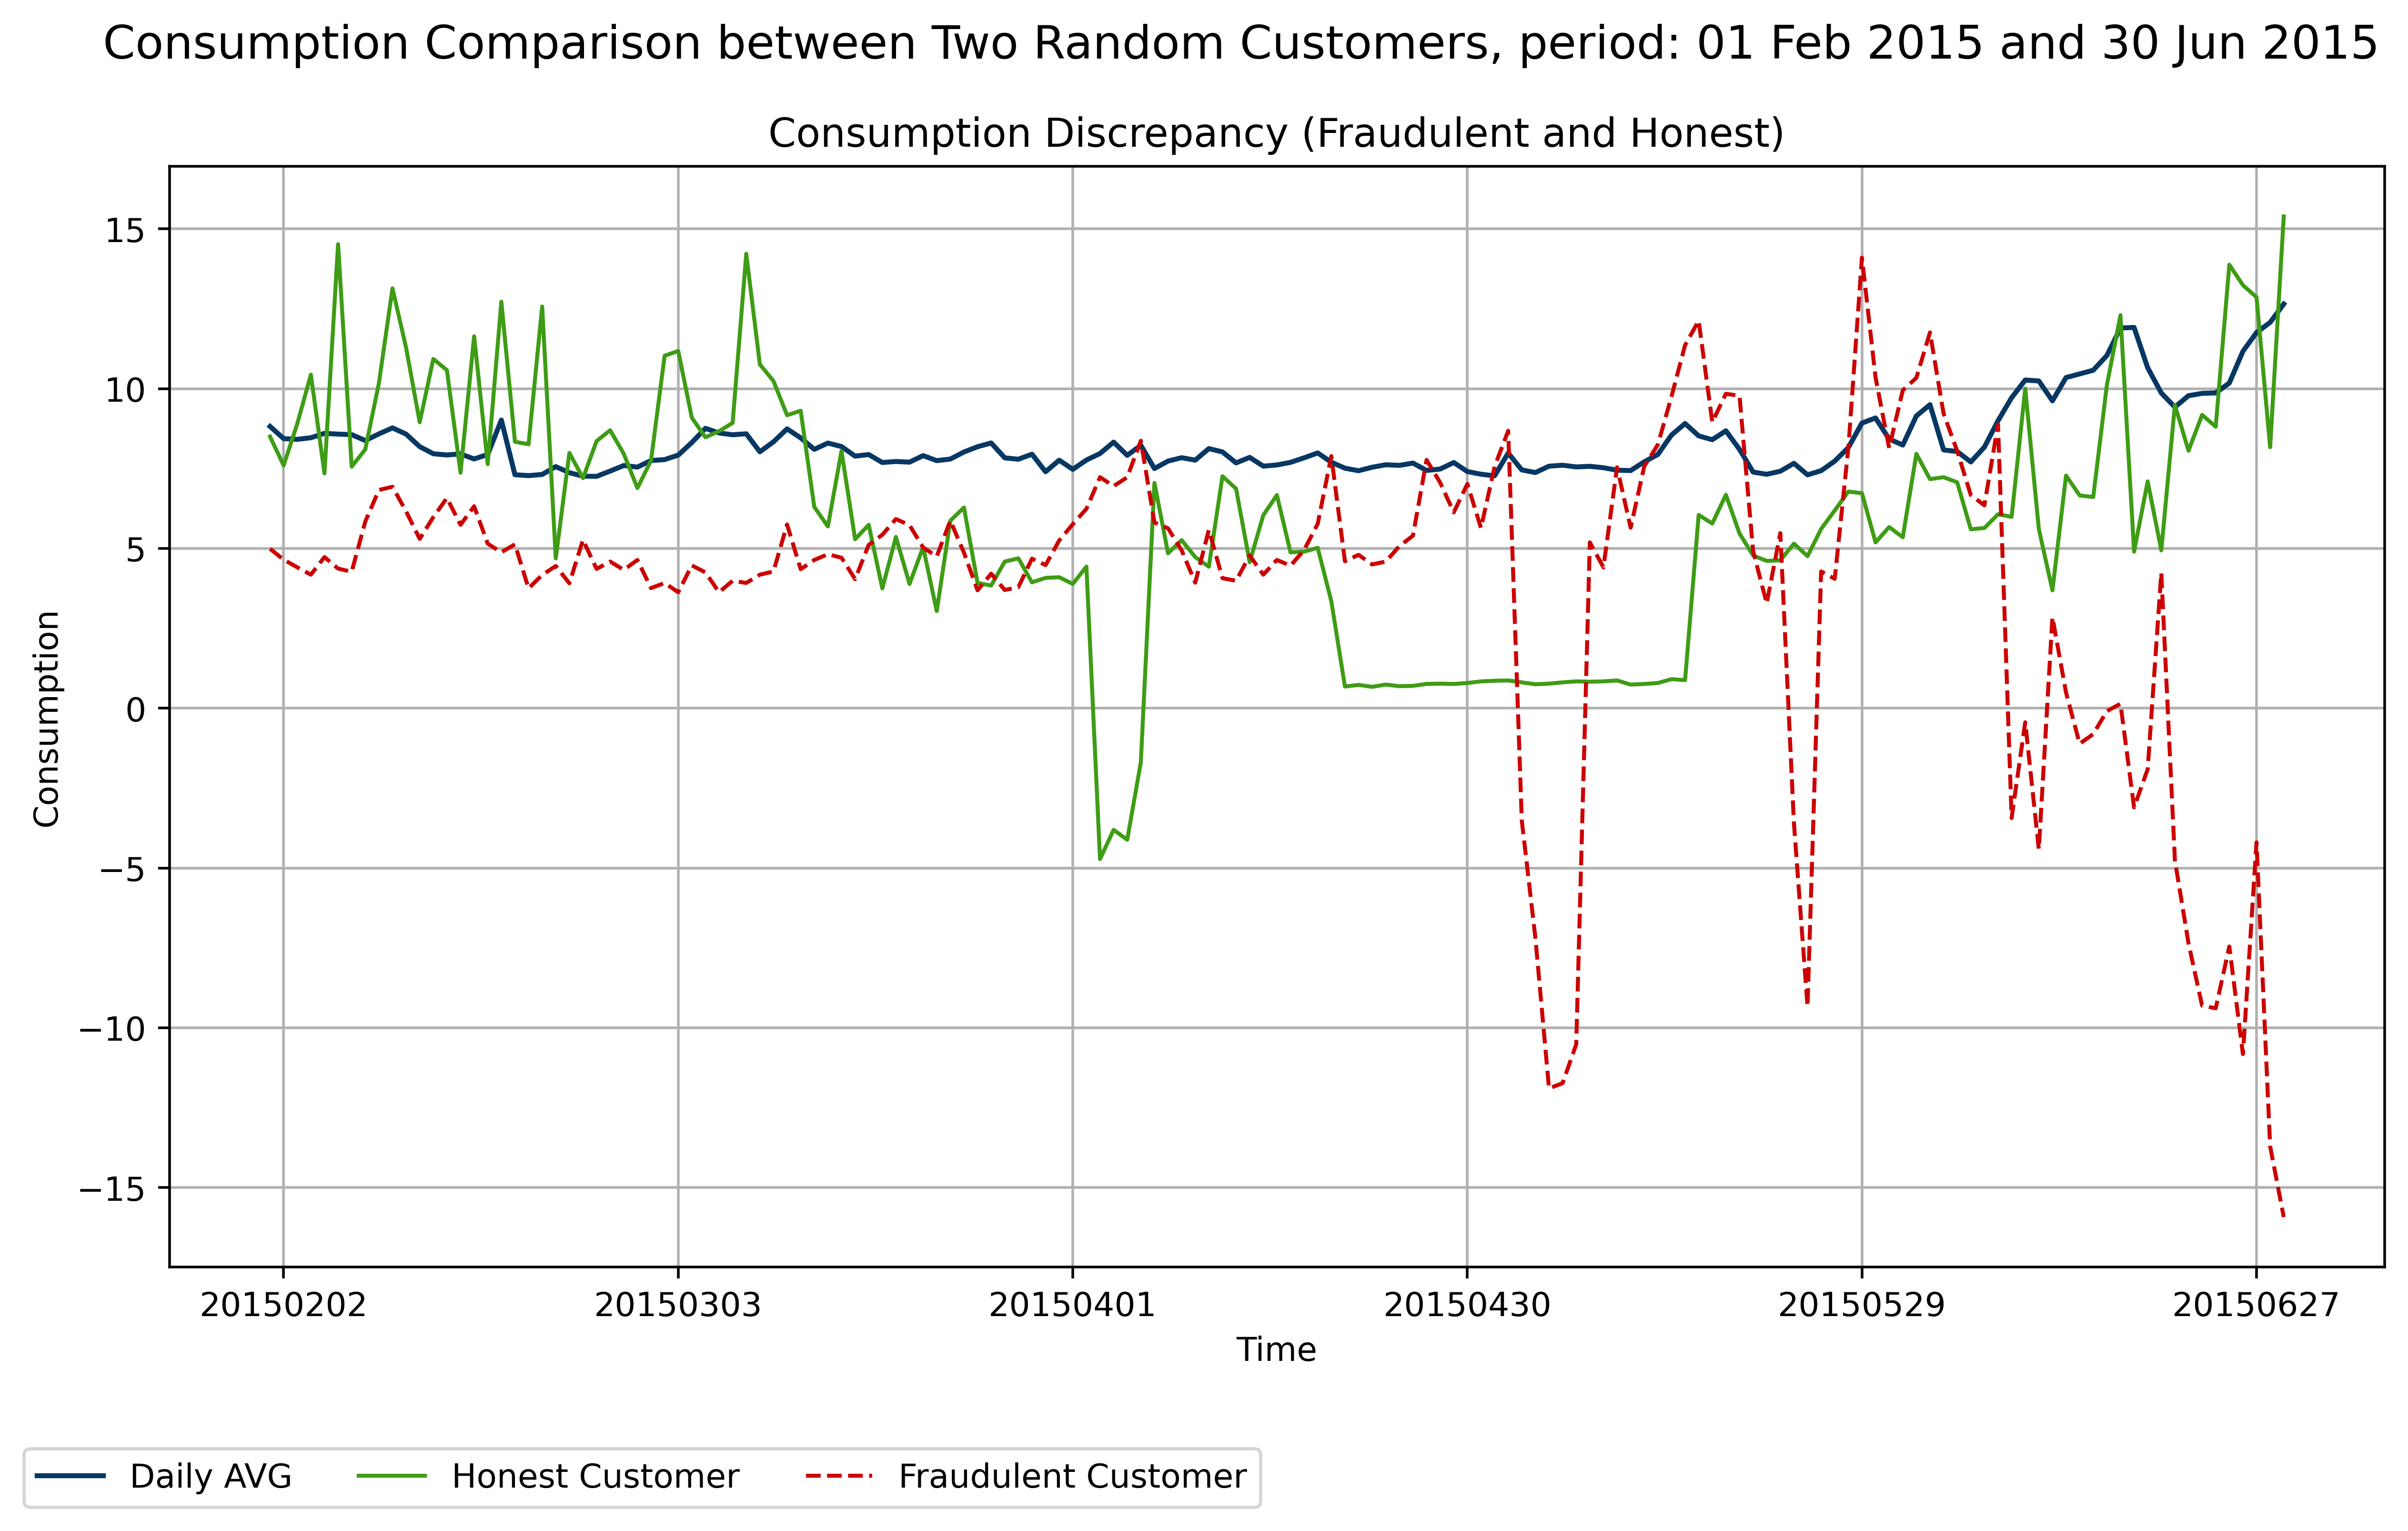

In [9]:
random_comparison(data, "20150201", "20150630")

In [10]:
def calculate_daily_by_category(df: pd.DataFrame, aggregated_df: pd.DataFrame):
    """Calculate daily consumption for each flag"""
    tot_cons = df.sum(axis=0).tolist()
    tot_cons.insert(0, 2)

    aggregated = aggregated_df.copy()
    aggregated.loc[len(aggregated)] = tot_cons

    # Map flag values to meaningful labels
    aggregated['FLAG'] = aggregated['FLAG'].map({
        0: 'Non-Fraudulent',
        1: 'Fraudulent',
        2: "Total",
    })
    return aggregated.melt(
        id_vars="FLAG", var_name="date", value_name="consumption")

In [11]:
def calculate_total_by_category(aggregated_df: pd.DataFrame):
    """Calculate total consumption for each flag"""
    consumption_by_cat = aggregated_df.sum(axis=1).reset_index()
    consumption_by_cat.columns = ['FLAG', 'Total Consumption']

    # Map flag values to meaningful labels
    consumption_by_cat['FLAG'] = consumption_by_cat['FLAG'].map({
        0: 'Non-Fraudulent',
        1: 'Fraudulent',
    })
    return consumption_by_cat

In [12]:
def total_consumption_comparison(
        df: pd.DataFrame,
        start_date: str = '20140101',
        end_date: str = '20161031'
    ) -> None:
    """
    Generate a graph comparing the total fraudulent consumption against
    the total non-fraudulent consumption for a specific time range.
    """
    # Filter data according to the specified interval [start_date:end_date)
    filtered_cons = filter_data_by_date(
        df, starting_date= start_date, ending_date=end_date)
    if filtered_cons is None:
        print(f"No data found for the range: {start_date} to {end_date}")
        return
    data = pd.concat([df[['FLAG']], filtered_cons], axis=1)

    # Group by FLAG to calculate total consumption for fraudulent (1)
    # and non-fraudulent (0) clients
    aggregated_by_flag = data.groupby('FLAG').sum().reset_index()

    # -------
    # Plot 1: Daily Trend Comparison between Categories 
    long_df = calculate_daily_by_category(filtered_cons, aggregated_by_flag)

    # -------
    # Plot 2: Comparison between Total Consumption by Category
    tot_cons_by_flag = calculate_total_by_category(aggregated_by_flag)
    total = tot_cons_by_flag['Total Consumption'].sum()
    fraud_total = tot_cons_by_flag.loc[
        tot_cons_by_flag.FLAG == "Fraudulent", "Total Consumption"].iloc[0]
    fraud_percent = (fraud_total / total) * 100

    # Plot definition
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]}, dpi=500)
    fig.suptitle(('Consumption Comparison by Category, '
                  'period: {} and {}'.format(
                      date_to_readable(start_date),
                      date_to_readable(end_date)
                    )), fontsize=14)
    sns.set_theme(style="whitegrid")  # Set the seaborn style

    # =========================================
    # [1] Cosumption trend plot
    styles = {
        'Fraudulent': {
            "color": '#cc0000',
            "linewidth": 1.2,
            "linestyle": "-"
        },
        'Non-Fraudulent': {
            "color": '#3e9c15',
            "linewidth": 1.2,
            "linestyle": "-"
        },
        'Total': {
            "color": '#073763',
            "linewidth": 1.5,
            "linestyle": "--"
        },
    }

    for category, group in long_df.groupby("FLAG"):
        ax1.plot(
            group["date"],
            group["consumption"],
            label=category,
            color=styles[category]["color"], # type: ignore
            linewidth=styles[category]["linewidth"], # type: ignore
            linestyle=styles[category]["linestyle"] # type: ignore
        )

    n_days = aggregated_by_flag.shape[1]
    ax1.set_xticks(range(1, n_days, int(n_days*.2)))
    ax1.tick_params(axis='x', rotation=20, labelsize=8)
    ax1.grid(True)

    # Manual creation of the legend and information setting
    custom_lines = [
        Line2D(
            [0], [0],
            color=styles["Fraudulent"]["color"],
            linewidth=styles["Fraudulent"]["linewidth"],
            linestyle=styles["Fraudulent"]["linestyle"]
        ),
        Line2D(
            [0], [0],
            color=styles["Non-Fraudulent"]["color"],
            linewidth=styles["Non-Fraudulent"]["linewidth"],
            linestyle=styles["Non-Fraudulent"]["linestyle"]
        ),
        Line2D(
            [0], [0],
            color=styles["Total"]["color"],
            linewidth=styles["Total"]["linewidth"],
            linestyle=styles["Total"]["linestyle"]
        ),
    ]
    ax1.legend(
        custom_lines,
        ["Fraudulent",
         "Non-Fraudulent",
         "Total Consumption"],
        title="Category", fontsize=8)
    ax1.set_title("Electricity Consumption Trend", fontsize=12)
    ax1.set_xlabel("Date", fontsize=10)
    ax1.set_ylabel("Daily Consumption", fontsize=10)

    # =========================================
    # [2] Plot the total consumption comparison
    # plt.subplot(1, 2, 2)
    sns.barplot(
        data=tot_cons_by_flag,
        x='FLAG',
        y='Total Consumption',
        ax=ax2,
        hue='FLAG',
        dodge=False,
        legend=False,
        palette=['#3e9c15', '#cc0000']
    )
    # Annotate the Fraudulent bar
    fraud_idx = tot_cons_by_flag[tot_cons_by_flag['FLAG'] == 'Fraudulent'].index[0]
    ax2.text(
        x=fraud_idx, 
        y=fraud_total + total * 0.01,  # Slight offset above the bar
        s=f"{fraud_percent:.2f}%", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black', 
        weight='bold'
    )
    ax2.tick_params(labelsize=8)
    ax2.yaxis.tick_right()
    ax2.set_title(f'Consumption Bar Chart', fontsize=12)
    ax2.set_xlabel('Client Type', fontsize=10)
    ax2.set_ylabel('Total Consumption', fontsize=10)

    fig.tight_layout()
    plt.show()

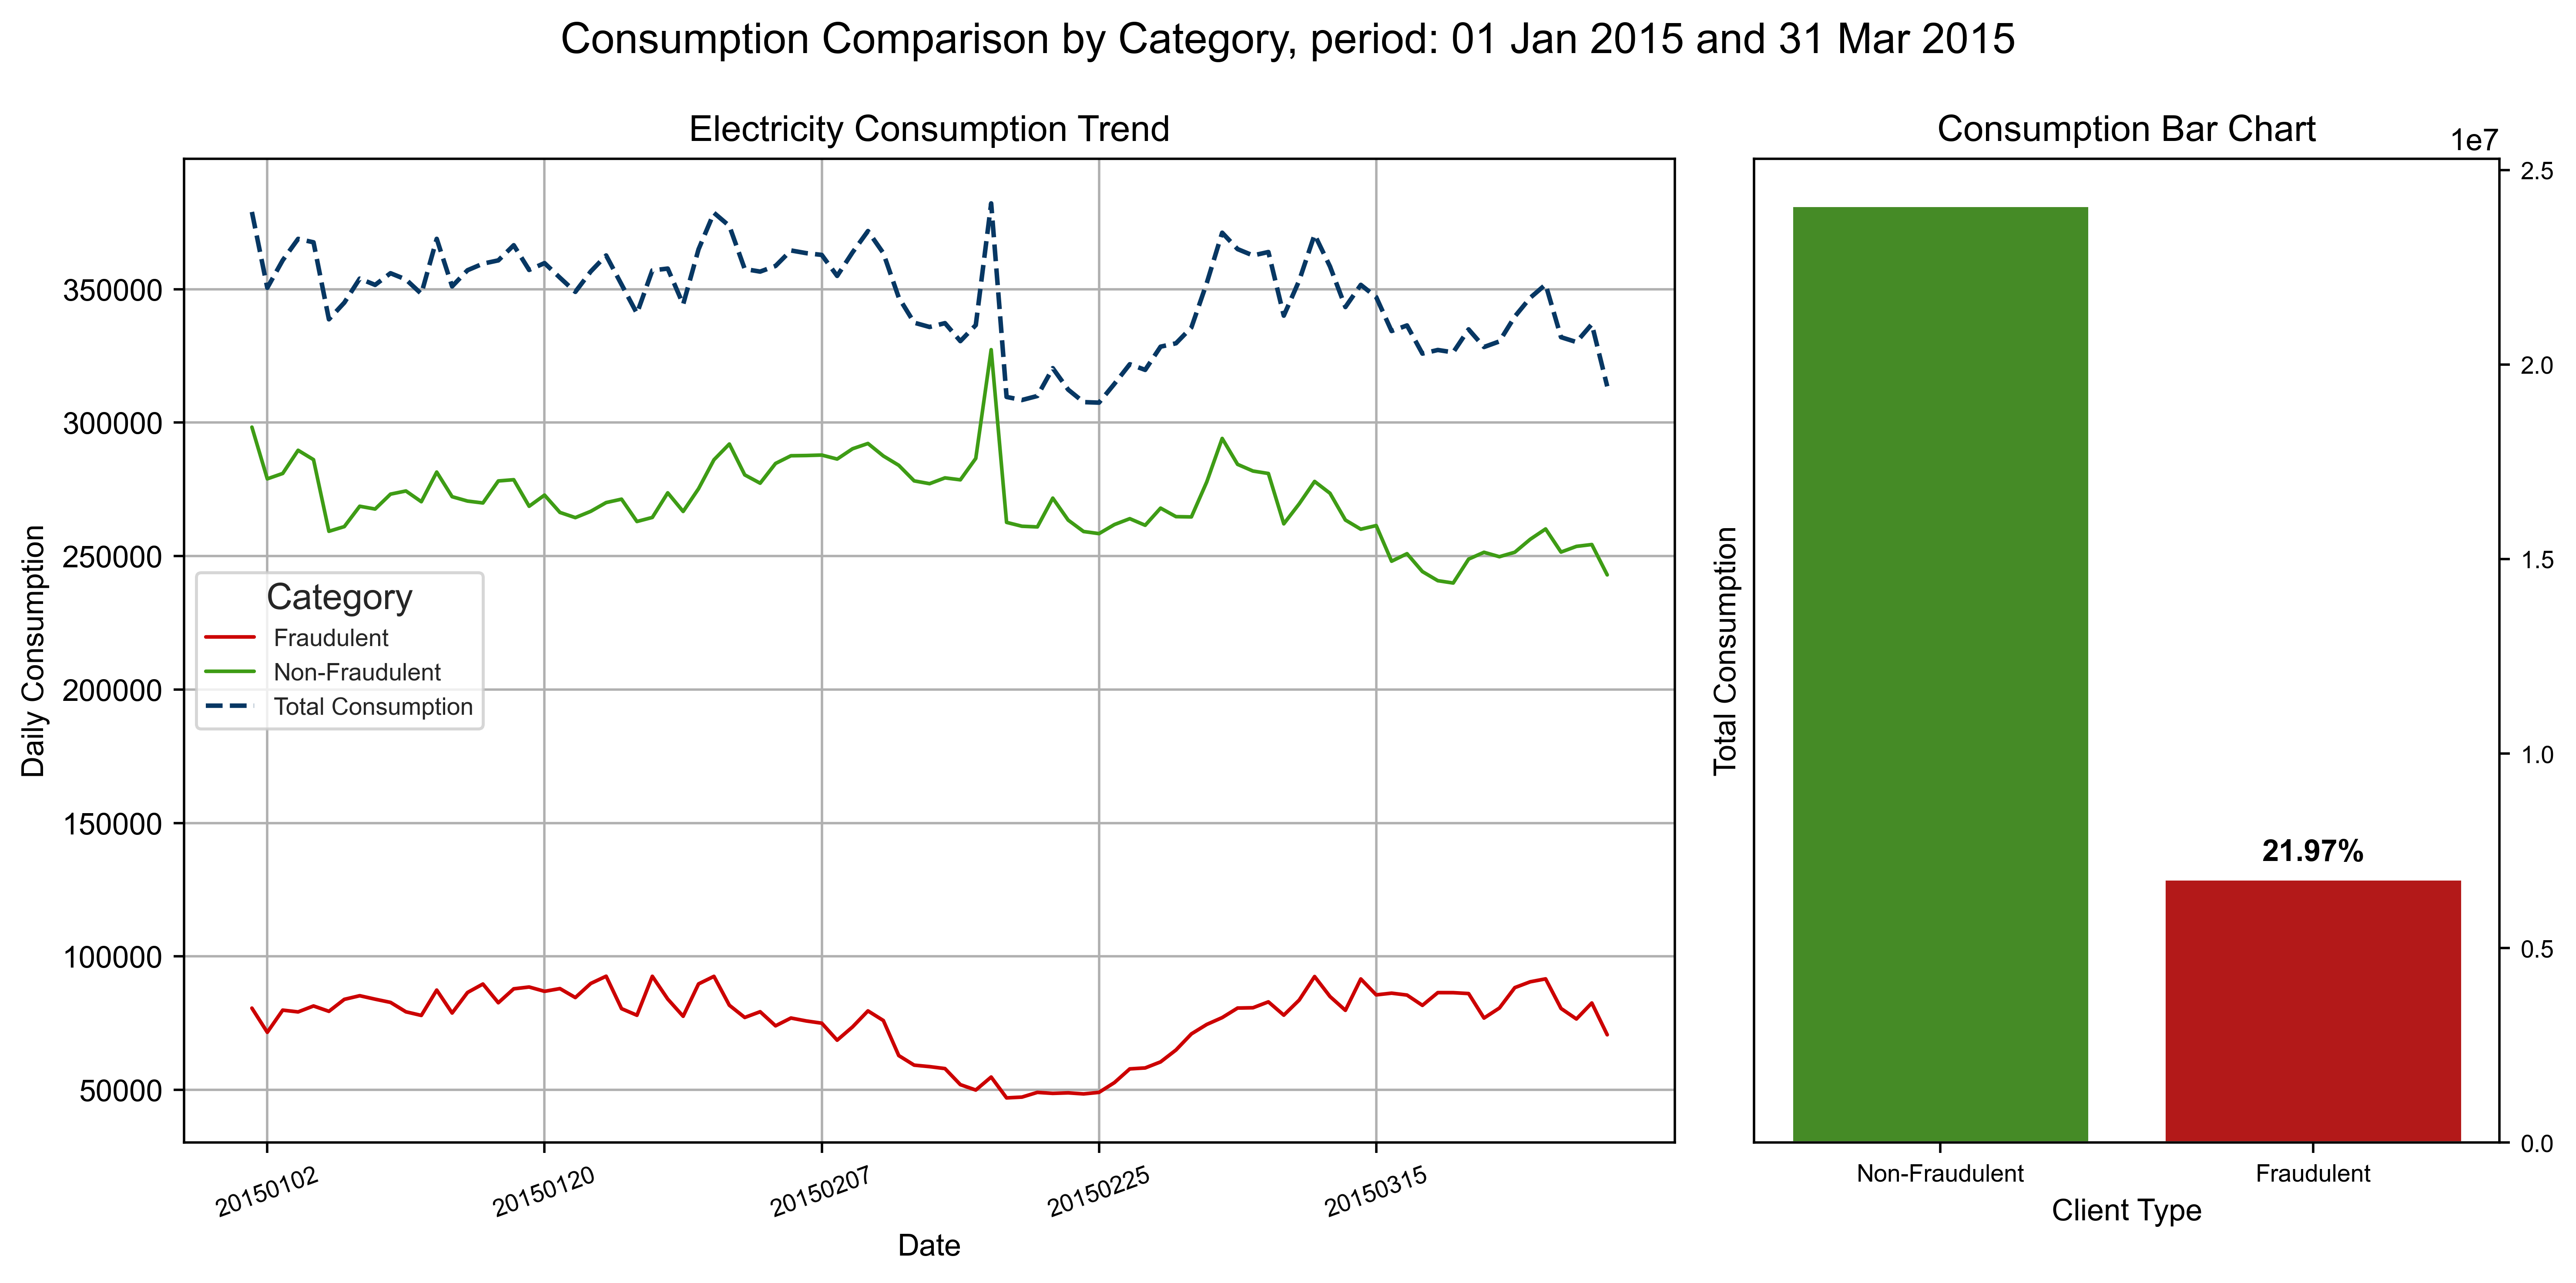

In [13]:
total_consumption_comparison(data, "20150101", "20150331")

## Training

In [14]:
train, test = sklearn.model_selection.train_test_split(data, test_size=.2, random_state=42, shuffle=True)

print(f"Training set instances:\t\t{len(train)}")
print(f"Validation set instances:\t{len(test)}")

Training set instances:		33897
Validation set instances:	8475


In [15]:
x_train = train.to_numpy()[:, :-2]
y_train = train[target].astype("int").astype("category")

In [16]:
x_test = test.to_numpy()[:, :-2]
y_test = test[target].astype("int").astype("category")

In [17]:
scaler = sklearn.preprocessing.StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)

In [18]:
clf = sklearn.linear_model.Perceptron(
    max_iter=3000,
    random_state=42
)
fitted_clf = clf.fit(scaled_x_train, y_train)

## Evaluation

In [19]:
y_pred = fitted_clf.predict(scaler.transform(x_test))
results = pd.DataFrame({"EXPECTED": y_test, "PREDICTED": y_pred})

In [20]:
results.head(15)

,EXPECTED,PREDICTED
15232,0,0
26804,0,0
28553,0,0
39245,0,0
38858,0,0
8869,0,1
12760,0,1
7524,0,1
30735,0,0
15601,0,0


In [21]:
fitted_clf.score(x_train, y_train)

0.14912824143729533

In [22]:
fitted_clf.score(x_test, y_test)

0.1487905604719764

In [23]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

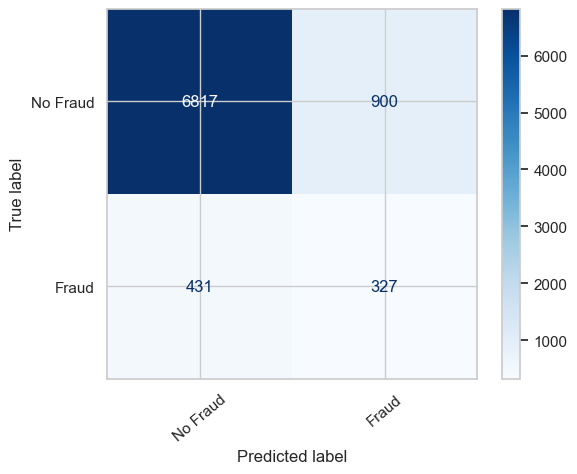

In [24]:
cm_display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=target_labels)

cm_display.plot(
    cmap=plt.cm.Blues, # type: ignore
    xticks_rotation=40
)
plt.show()

In [25]:
avg_metrics = {
    "accuracy": sklearn.metrics.accuracy_score(y_test, y_pred),
    "precision": sklearn.metrics.precision_score(
        y_test, y_pred,
        labels=target_labels),
    "sensitivity": sklearn.metrics.recall_score(
        y_test, y_pred,
        labels=target_labels),
    "f1_score": sklearn.metrics.f1_score(
        y_test, y_pred,
        labels=target_labels)
}

In [26]:
avg_metrics

{'accuracy': 0.8429498525073746,
 'precision': 0.2665036674816626,
 'sensitivity': 0.4313984168865435,
 'f1_score': 0.3294710327455919}

In [27]:
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    No Fraud       0.94      0.88      0.91      7717
       Fraud       0.27      0.43      0.33       758

    accuracy                           0.84      8475
   macro avg       0.60      0.66      0.62      8475
weighted avg       0.88      0.84      0.86      8475

